## The project: Predict travel insurance claims

We use the "Travel Insurance" dataset from Zahier Nasrudin, published on Kaggle (Nasrudin, 2019). It contains data from a third-party insurance servicing company based in Singapore. &nbsp;

The target in the data is a binary variable indicating whether the policy holder filed a claim against the insurance company. This target will be predicted using as features characteristics of the travel insurance holders, attributes of the associated trips, as well as attributes of the insurance products purchased. Specifically, the used features are: agency, agency type, travel insurance product type (e.g. cancellation, rental vehicel, ticket protector), distribution channel (online, offline), country of destination, trip duration, net sales, commision, as well as gender and age of the policy holder.
&nbsp;

Link to data: https://www.kaggle.com/datasets/mhdzahier/travel-insurance

In [ ]:
!pip install -U sagemaker

In [ ]:
!pip install -U boto3

In [ ]:
# For .info() method to run below, need to older version of numpy
!pip install numpy==1.18.1

In [1]:
import sagemaker
import pandas as pd
import numpy as np
from platform import python_version
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
import os
import sagemaker
import boto3
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.xgboost.estimator import XGBoost

In [2]:
python_version(), np.__version__

('3.7.10', '1.18.1')

In [3]:
sagemaker.__version__, boto3.__version__

('2.107.0', '1.26.8')

### (1-a) Download data from Kaggle into Jupyter NB instance folder, load data into Jupyter NB environment

(1) Download the authentication json file ('kaggle.json') from Kaggle & upload it to the notebook file directory <br>
(2) Run the following code in bash terminal to download the travel insurance dataset from Kaggle

In [ ]:
# pip install kaggle
# mkdir ~/.kaggle
# cp kaggle.json ~/.kaggle/
# chmod 600 .kaggle/kaggle.json
# cd ml_eng_capstone
# kaggle datasets download -d mhdzahier/travel-insurance

Load data persisted on Jupyter notebook instance into Jupyter notebook environment

In [35]:
with zipfile.ZipFile('travel-insurance.zip', 'r') as zip_ref:
    zip_ref.extractall()
travel_insurance_df = pd.read_csv('travel insurance.csv')

### (1-b) Inspect & clean data

In [36]:
travel_insurance_df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Gender,Age
0,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,81
1,CBH,Travel Agency,Offline,Comprehensive Plan,No,186,MALAYSIA,-29.0,9.57,F,71
2,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,65,AUSTRALIA,-49.5,29.70,NaN,32
3,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,60,AUSTRALIA,-39.6,23.76,NaN,32
4,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,No,79,ITALY,-19.8,11.88,NaN,41


In [ ]:
travel_insurance_df.info()

In [ ]:
travel_insurance_df.isnull().sum()

Describe numerical values:

In [ ]:
print('Duration:')
print(travel_insurance_df['Duration'].describe())
print()
print('Commision (in value):')
print(travel_insurance_df['Commision (in value)'].describe())
print()
print('Age:')
print(travel_insurance_df['Age'].describe())

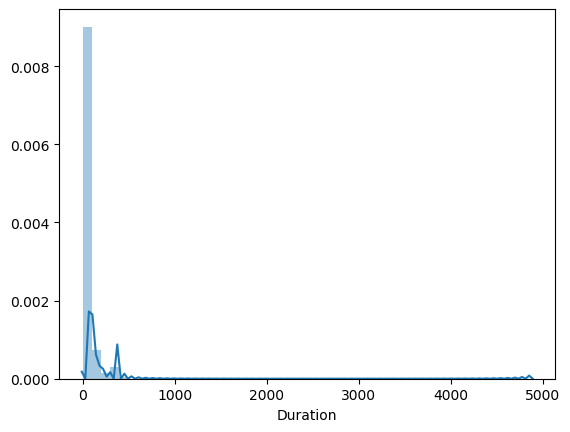

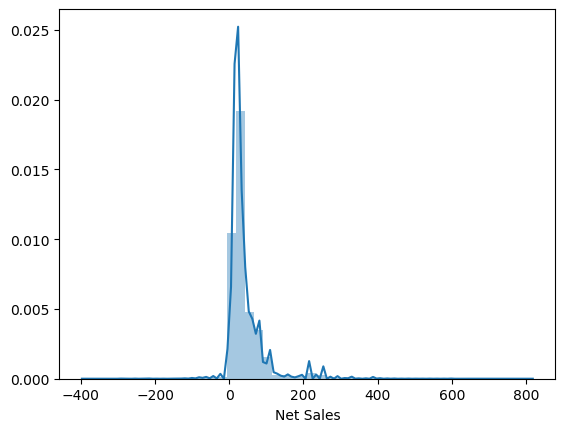

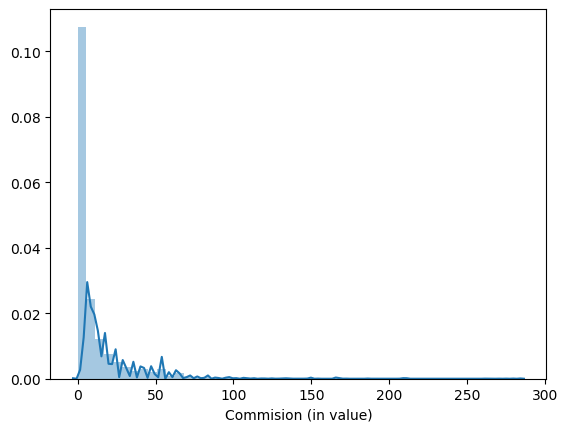

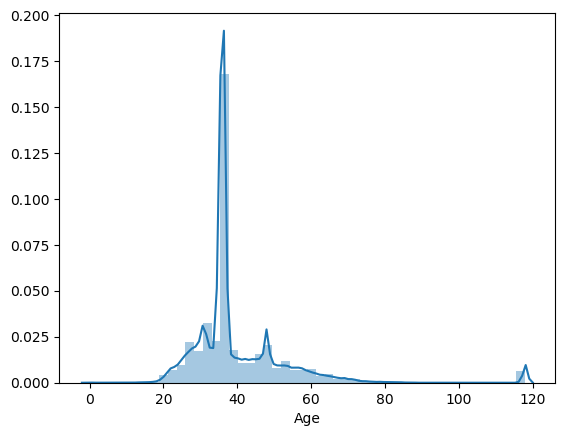

In [37]:
travel_insurance_sub = travel_insurance_df[['Duration', 'Net Sales', 'Commision (in value)', 'Age']]
for i, col in enumerate(travel_insurance_sub):
    plt.figure(i)
    sns.distplot(travel_insurance_sub[col])

Duration: Drop rows with negative values

In [ ]:
len(travel_insurance_df[travel_insurance_df['Duration']<0])

In [38]:
index_neg_duration = travel_insurance_df[travel_insurance_df['Duration']<0].index
travel_insurance_df.drop(index_neg_duration, inplace=True)
travel_insurance_df = travel_insurance_df.reset_index().drop(labels='index', axis=1)
travel_insurance_df.shape

(63321, 11)

Duration: Drop rows with extremely high values (upward outliers)

In [39]:
pd.set_option('display.max_rows', 50)
travel_insurance_df['Duration'].value_counts().sort_index(ascending = False).head(40)

4881    1
4857    1
4847    1
4844    1
4831    1
4829    1
4815    1
4784    1
4738    1
4736    1
4685    1
4652    1
4609    1
4580    1
740     1
547     1
545     1
531     1
529     2
519     1
512     1
508     2
497     1
494     1
490     1
488     1
487     1
478     1
474     1
472     2
466     3
465     1
463     2
461     1
459     1
457     2
456     2
450     1
448     2
445     1
Name: Duration, dtype: int64

In [40]:
index_high_duration = travel_insurance_df[travel_insurance_df['Duration']>500].index
travel_insurance_df.drop(index_high_duration, inplace=True)
travel_insurance_df = travel_insurance_df.reset_index().drop(labels='index', axis=1)

In [ ]:
travel_insurance_df.shape

In [41]:
travel_insurance_df['Age'].value_counts().sort_index(ascending = False).head(10)

118    979
88       4
87       8
86       4
85       9
84      20
83      18
82      17
81      23
80      21
Name: Age, dtype: int64

Upward outliers in age (118) will be replaced by next best "realistic" value (88), effectively introducing an age cap at 88

In [42]:
travel_insurance_df['Age'] = np.where(travel_insurance_df['Age'] == 118, 88, travel_insurance_df['Age'])

Replace NAs (only in Gender column) by string 'UNKNOWN'

In [43]:
travel_insurance_df.Gender.isna().sum()

45089

In [44]:
travel_insurance_df.fillna('UNKNOWN',inplace=True)

In [ ]:
##Remove rows with missing data:
#travel_insurance_df = travel_insurance_df.dropna()
#travel_insurance_df = travel_insurance_df.reset_index().drop(labels='index', axis=1)

Overview over data:

In [ ]:
no_instances = travel_insurance_df.shape[0]
no_features = len(travel_insurance_df.columns) - 1
target_shares = round(travel_insurance_df['Claim'].value_counts()/len(travel_insurance_df),3)
print("No. of instances: " + f"{no_instances:,}")
print("No. of columns: " + str(no_features))
print("Share of targets: \n" + str(target_shares))
travel_insurance_df.head()

In [ ]:
## Pie chart
#count_agency = pd.DataFrame(travel_insurance_df['Agency'].value_counts())
#count_agency['Count'] = count_agency['Agency']
#count_agency['Agency'] = count_agency.index
#count_agency.reset_index(inplace=True)
#count_agency.drop(columns='index', inplace=True)
#count_agency.groupby(['Agency']).sum().plot(kind='pie', y='Count', autopct='%1.0f%%', title='Points Scored by Team')

In [45]:
feat_list = ['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination']
num_rows = len(travel_insurance_df)
for feat in feat_list:
    value_counts_df = pd.DataFrame(travel_insurance_df[feat].value_counts())
    value_counts_df['Count'] = value_counts_df[feat]
    value_counts_df[feat] = value_counts_df.index
    value_counts_df.reset_index(inplace=True)
    value_counts_df.drop(columns='index', inplace=True)
    value_counts_df['Share (in %)'] = round(value_counts_df['Count']/num_rows, 4)*100
    print(value_counts_df.head(25))
    print()

   Agency  Count  Share (in %)
0     EPX  35119         55.48
1     CWT   8580         13.56
2     C2B   8260         13.05
3     JZI   6324          9.99
4     SSI   1042          1.65
5     JWT    749          1.18
6     RAB    725          1.15
7     LWC    686          1.08
8     TST    528          0.83
9     KML    392          0.62
10    ART    331          0.52
11    CCR    194          0.31
12    CBH    101          0.16
13    TTW     98          0.15
14    CSR     86          0.14
15    ADM     82          0.13

     Agency Type  Count  Share (in %)
0  Travel Agency  45866         72.46
1       Airlines  17431         27.54

  Distribution Channel  Count  Share (in %)
0               Online  62190         98.25
1              Offline   1107          1.75

                            Product Name  Count  Share (in %)
0                      Cancellation Plan  18630         29.43
1               2 way Comprehensive Plan  13158         20.79
2        Rental Vehicle Excess Insuran

### (1-c) Prep data & save on Jupyter NB instance

Recode target ('Claim') into numerical variable:

In [46]:
dict_label = {'Yes' : 1, 'No' : 0}
travel_insurance_df['Claim'] = travel_insurance_df['Claim'].replace(dict_label)

Replace categorical features through one-hot encoding:

In [ ]:
travel_insurance_df.columns

Categorical features are transformed into dummy variables. Given the non-ordinal nature of the categorical features ('Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Destination', 'Gender') we use one-hot encoding instead of label encoding. The last dummy column of each categorical feature is excluded to avoid perfect collinearity.

In [47]:
def one_hot(df):
    #Function performs one-hot encoding with features of datatype object (string)lit
    #Last dummy column of each categorical feature is excluded to avoid perfect collinearity
    #NOTE: Categorical features already encoded as integers are NOT identified by this function!
    dtypes_ser = df.dtypes
    dtypes_df = dtypes_ser.to_frame().reset_index()
    dtypes_df = dtypes_df.rename(columns = {'index':'column', 0:'dtype'})
    categ_list = list(dtypes_df['column'][dtypes_df['dtype']=='object'])
    for feat in categ_list:
        one_hot = pd.get_dummies(df[feat], prefix=feat, drop_first=True)
        df = df.join(one_hot)
        df.drop(feat, inplace=True, axis=1)
    return df

In [48]:
travel_insurance_df = one_hot(travel_insurance_df)

In [ ]:
travel_insurance_df.info()

In [ ]:
travel_insurance_df.info()

Train-test split <br>
(Note: test data is without label)

In [49]:
travel_insurance_df_train, travel_insurance_df_test = train_test_split(travel_insurance_df, test_size = 0.2, 
                                                                 stratify = travel_insurance_df['Claim'], 
                                                                 shuffle = True, 
                                                                 random_state = 1)
travel_insurance_df_test_x = travel_insurance_df_test.drop(labels='Claim', axis = 1)
travel_insurance_df_test_y = pd.DataFrame(travel_insurance_df_test['Claim'])

In [50]:
travel_insurance_df_train.shape, travel_insurance_df_test_x.shape

((50637, 197), (12660, 196))

In [ ]:
data_dir = '../ml_eng_capstone/data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
travel_insurance_df_train.to_csv(data_dir + '/' + 'train.csv', header = False, index = False)
travel_insurance_df_test_x.to_csv(data_dir + '/' + 'test.csv', header = False, index = False)
travel_insurance_df_test_y.to_csv(data_dir + '/' + 'test_y.csv', header = True, index = False)

### (2-a) Create Sagemaker objects

In [6]:
sm_session = sagemaker.Session()
sm_role = sagemaker.get_execution_role()
bucket = sm_session.default_bucket()

In [7]:
sm_session, sm_role, bucket

(<sagemaker.session.Session at 0x7ffac92b1c90>,
 'arn:aws:iam::821983426621:role/service-role/AmazonSageMaker-ExecutionRole-20220516T003179',
 'sagemaker-eu-central-1-821983426621')

In [8]:
prefix = 'travel_insurance_claim_data'

### (2-b) Load train and test data to S3

In [10]:
data_dir = '../ml_eng_capstone/data'
train_path_s3 = sm_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
test_path_s3 = sm_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

In [11]:
# Overview on files on S3
bucket_list = []
for i in boto3.resource('s3').Bucket(bucket).objects.all():
    bucket_list.append(i)
bucket_list

[s3.ObjectSummary(bucket_name='sagemaker-eu-central-1-821983426621', key='sagemaker-scikit-learn-2022-11-13-20-35-15-834/source/sourcedir.tar.gz'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-central-1-821983426621', key='travel_insurance_claim_data/output/sagemaker-scikit-learn-2022-11-13-20-35-15-834/debug-output/training_job_end.ts'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-central-1-821983426621', key='travel_insurance_claim_data/output/sagemaker-scikit-learn-2022-11-13-20-35-15-834/output/model.tar.gz'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-central-1-821983426621', key='travel_insurance_claim_data/output/sagemaker-scikit-learn-2022-11-13-20-35-15-834/profiler-output/framework/training_job_end.ts'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-central-1-821983426621', key='travel_insurance_claim_data/output/sagemaker-scikit-learn-2022-11-13-20-35-15-834/profiler-output/system/incremental/2022111320/1668371820.algo-1.json'),
 s3.ObjectSummary(bucket_name='sagemaker-eu-cent

In [ ]:
#Delete data files in s3://sagemaker-us-east-1-786251868139/travel_insurance_claim_data/
#boto3.resource('s3').Bucket(bucket).objects.all().delete()

### (3-a)	Train Random Forest w custom scikit-learn estimator - baseline

In [ ]:
!pygmentize source/train_rf.py

In [13]:
est_rf_base = SKLearn(entry_point = 'train_rf.py',
                       source_dir = 'source',
                       role = sm_role,
                       framework_version = '0.23-1',
                       py_version = 'py3',
                       instance_count = 1,
                       instance_type = 'ml.m4.xlarge',
                       output_path = 's3://{}/{}/output'.format(bucket, prefix),
                       sagemaker_session = sm_session
                       #hyperparameters = {'n_estimators':100, 'min_samples_split':2, 'min_samples_leaf':1, 'max_depth':None, 'max_leaf_nodes':None}
                     )

In [14]:
est_rf_base.fit({'train' : train_path_s3})

2022-11-14 08:15:05 Starting - Starting the training job...ProfilerReport-1668413704: InProgress
...
2022-11-14 08:15:58 Starting - Preparing the instances for training.........
2022-11-14 08:17:31 Downloading - Downloading input data.....2022-11-14 08:18:18,198 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-11-14 08:18:18,201 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-14 08:18:18,212 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-11-14 08:18:18,420 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-14 08:18:18,435 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-14 08:18:18,449 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-14 08:18:18,459 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework

### (3-b)	Train SVM w custom scikit-learn estimator - baseline

In [18]:
### (3-b) Train XGBOOST model with SageMaker in-built algorithm (baseline B)

In [15]:
est_svm_base = SKLearn(entry_point = 'train_svm.py',
                       source_dir = 'source',
                       role = sm_role,
                       framework_version = '0.23-1',
                       py_version = 'py3',
                       instance_count = 1,
                       instance_type = 'ml.m4.xlarge',
                       output_path = 's3://{}/{}/output'.format(bucket, prefix),
                       sagemaker_session = sm_session
                       #hyperparameters = {'C':1, 'gamma':0.01}
                     )

In [16]:
est_svm_base.fit({'train' : train_path_s3})

2022-11-14 08:20:47 Starting - Starting the training job...
2022-11-14 08:21:12 Starting - Preparing the instances for trainingProfilerReport-1668414046: InProgress
............
2022-11-14 08:23:11 Downloading - Downloading input data...
2022-11-14 08:23:32 Training - Training image download completed. Training in progress.2022-11-14 08:23:36,933 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-11-14 08:23:36,936 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-14 08:23:36,947 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-11-14 08:23:37,143 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-14 08:23:37,156 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-14 08:23:37,169 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-11-14 08:23:37,180 sagemaker-tr

### (3-c)	Train XGBOOST model (Sagemaker in-built algorithm) - baseline

In [71]:
# Alternative: XGBOOST (built-in)
xgb_image = sagemaker.image_uris.retrieve('xgboost', sm_session.boto_region_name, 'latest')

In [84]:
est_xgb_base = \
    sagemaker.estimator.Estimator(xgb_image, # The image name of the training container
                                  sm_role, # The IAM role to use (our current role in this case)
                                  instance_count = 1, # The number of instances to use for training
                                  instance_type = 'ml.m4.xlarge', # The type of instance to use for training
                                  output_path = 's3://{}/{}/output'.format(sm_session.default_bucket(), prefix), # Where to save the output (the model artifacts)
                                  sagemaker_session = sm_session) # The current SageMaker session

In [90]:
est_xgb_base.set_hyperparameters(max_depth = 5,
                                 objective = 'binary:logistic',
                                 num_round=200)

In [92]:
train_path_s3

's3://sagemaker-eu-central-1-821983426621/travel_insurance_claim_data/train.csv'

In [94]:
from sagemaker.inputs import TrainingInput
train_input = TrainingInput(train_path_s3, content_type = 'csv')

In [96]:
est_xgb_base.fit({'train' : train_input})

2022-11-14 11:36:00 Starting - Starting the training job...ProfilerReport-1668425760: InProgress
...
2022-11-14 11:36:52 Starting - Preparing the instances for training.........
2022-11-14 11:38:30 Downloading - Downloading input data...
2022-11-14 11:38:55 Training - Downloading the training image...
2022-11-14 11:39:16 Training - Training image download completed. Training in progress..Arguments: train
[2022-11-14:11:39:28:INFO] Running standalone xgboost training.
[2022-11-14:11:39:28:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-11-14:11:39:28:INFO] File size need to be processed in the node: 19.39mb. Available memory size in the node: 8618.56mb
[2022-11-14:11:39:28:INFO] Determined delimiter of CSV input is ','
[11:39:28] S3DistributionType set as FullyReplicated
[11:39:28] 50637x196 matrix with 9924852 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[11:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nod

### (4-a) Load test data labels from Jupyter NB instance (csv)

In [65]:
travel_insurance_df_test_y = pd.read_csv(data_dir + '/' + 'test_y.csv')

### (4-b) Test RF baseline model with batch transform (SageMaker Python SDK)

##### Batch transform with SageMaker SDK (needs estimator_obj in notebook environment)

In [21]:
transform_rf_base = est_rf_base.transformer(instance_count = 1, 
                                            instance_type = 'ml.m4.xlarge')
transform_rf_base.transform(test_path_s3, content_type = 'text/csv', split_type = 'Line')

.................................
2022-11-14 08:52:59,688 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-11-14 08:52:59,691 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-11-14 08:52:59,692 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
    

In [23]:
transform_rf_base.output_path

's3://sagemaker-eu-central-1-821983426621/sagemaker-scikit-learn-2022-11-14-08-47-42-530'

In [176]:
# Copy predictions from batch transform job to Jupyter NB instance folder & rename file
!aws s3 cp --recursive $transform_rf_base.output_path $data_dir
!mv data/test.csv.out data/base_rf_test.csv.out

download: s3://sagemaker-eu-central-1-821983426621/sagemaker-scikit-learn-2022-11-14-08-47-42-530/test.csv.out to data/test.csv.out


In [182]:
predict_rf_base = pd.read_csv(os.path.join(data_dir, 'base_rf_test.csv.out'), header=None)

In [183]:
predict_rf_base

,0,1,2,3,4,5,6,7,8,9,...,12650,12651,12652,12653,12654,12655,12656,12657,12658,12659
0,[0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0]


In [184]:
predict_rf_base = predict_rf_base.transpose()
predict_rf_base = predict_rf_base.replace('[0','0')
predict_rf_base = predict_rf_base.replace(' 0]','0')
predict_rf_base = predict_rf_base.astype('int64')

In [163]:
print('Accuracy RF (baseline model) is: ' + str(round(accuracy_score(travel_insurance_df_test_y, predict_xgb_base),4)))
print('Recall RF (baseline model) is: ' + str(round(recall_score(travel_insurance_df_test_y, predict_xgb_base),4)))

Accuracy RF (baseline model) is: 0.9852
Recall RF (baseline model) is: 0.0


### (4-c) Test XGBOOST baseline model with batch transform (SageMaker Python SDK)

In [ ]:
training_job_name = est_xgb_base._current_job_name

In [103]:
transform_xgb_base = est_xgb_base.transformer(instance_count = 1, 
                                              instance_type = 'ml.m4.xlarge')
transform_xgb_base.transform(test_path_s3, content_type = 'text/csv', split_type = 'Line')

..................................Arguments: serve
[2022-11-14 12:45:06 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2022-11-14 12:45:06 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2022-11-14 12:45:06 +0000] [1] [INFO] Using worker: gevent
[2022-11-14 12:45:06 +0000] [21] [INFO] Booting worker with pid: 21
[2022-11-14 12:45:06 +0000] [22] [INFO] Booting worker with pid: 22
[2022-11-14 12:45:06 +0000] [23] [INFO] Booting worker with pid: 23
[2022-11-14 12:45:06 +0000] [24] [INFO] Booting worker with pid: 24
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_

In [104]:
transform_xgb_base.output_path

's3://sagemaker-eu-central-1-821983426621/xgboost-2022-11-14-12-39-30-471'

In [177]:
# Copy predictions from batch transform job to Jupyter NB instance folder & rename file
!aws s3 cp --recursive $transform_xgb_base.output_path $data_dir
!mv data/test.csv.out data/base_xgb_test.csv.out

download: s3://sagemaker-eu-central-1-821983426621/xgboost-2022-11-14-12-39-30-471/test.csv.out to data/test.csv.out


In [180]:
predict_xgb_base = pd.read_csv(os.path.join(data_dir, 'base_xgb_test.csv.out'), header=None)
predict_xgb_base['Claim_Pred'] = np.where(predict_xgb_base[0] > 0.2, 1, 0)
predict_xgb_base = predict_xgb_base.drop(0, axis = 1)

In [181]:
print('Accuracy RF (baseline model) is: ' + str(round(accuracy_score(travel_insurance_df_test_y, predict_xgb_base),4)))
print('Recall RF (baseline model) is: ' + str(round(recall_score(travel_insurance_df_test_y, predict_xgb_base),4)))

Accuracy RF (baseline model) is: 0.9803
Recall RF (baseline model) is: 0.0378


### (4-d) Test RF baseline model with batch transform (AWS SDK boto3)

In [174]:
training_job_name = est_rf_base._current_job_name
training_job_name

'sagemaker-scikit-learn-2022-11-14-08-15-04-646'

In [175]:
training_job_info = sm_session.sagemaker_client.describe_training_job(TrainingJobName = training_job_name)
model_artifacts_paths3 = training_job_info['ModelArtifacts']['S3ModelArtifacts']
training_image = training_job_info['AlgorithmSpecification']['TrainingImage']

In [ ]:
primary_container = {"Image" : training_image, 
                     "ModelDataUrl" : model_artifacts_paths3}
model_name= training_job_info['TrainingJobName'] + '-model'
model_info = sm_session.sagemaker_client.create_model(ModelName = model_name,
                                                      ExecutionRoleArn = sm_role,
                                                      PrimaryContainer = primary_container)

In [ ]:
transform_job_name = training_job_info['TrainingJobName'] + '-transform-job'
transform_output_path = "s3://{}/{}/batch-transform/".format(sm_session.default_bucket(),prefix)

In [ ]:
transform_request = {
    "TransformJobName" : transform_job_name,
    "ModelName" : model_name,
    "MaxConcurrentTransforms": 1,
    "MaxPayloadInMB" : 6,
    "BatchStrategy" : "MultiRecord",
    "TransformOutput" : {
        "S3OutputPath" : transform_output_path
    },
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_path_s3,
            }
        }
    },
    "TransformResources": {
        "InstanceType": "ml.m4.xlarge",
        "InstanceCount": 1
    }
}

In [ ]:
transform_response = sm_session.sagemaker_client.create_transform_job(**transform_request)
transform_desc = sm_session.wait_for_transform_job(transform_job_name)

### (4-y) OLD: Test SVM baseline model with batch transform (SageMaker Python SDK)

In [67]:
transform_svm_base = est_svm_base.transformer(instance_count = 1, 
                                              instance_type = 'ml.m4.xlarge')
transform_svm_base.transform(test_path_s3, content_type = 'text/csv', split_type = 'Line')

.................................2022-11-14 09:27:20,112 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-11-14 09:27:20,115 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-11-14 09:27:20,115 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
     

UnexpectedStatusException: Error for Transform job sagemaker-scikit-learn-2022-11-14-09-21-58-867: Failed. Reason: AlgorithmError: See job logs for more information

In [ ]:
transform_svm_base.output_path, data_dir

In [ ]:
# Copy predictions from batch transform job to Jupyter NB instance folder & rename file
!aws s3 cp --recursive $transform_svm_base.output_path $data_dir
!mv data/test.csv.out data/base_svm_test.csv.out

In [ ]:
predict_svm_base = pd.read_csv(os.path.join(data_dir, 'base_svm_test.csv.out'), header=None)
print('Accuracy SVM (base) is: ' + str(round(accuracy_score(travel_insurance_df_test_y, predict_svm_base.transpose()),4)))
print('Recall SVM (base) is: ' + str(round(recall_score(travel_insurance_df_test_y, predict_svm_base.transpose()),4)))

### (4-z) Test SVM baseline model with batch transform (AWS SDK boto3)

Due to Kernel shutdown need to create batch transform job from training job run before (model artifacts stored on S3) 

In [98]:
training_job_info = sm_session.sagemaker_client.describe_training_job(TrainingJobName='sagemaker-scikit-learn-2022-11-14-08-20-46-766')
model_artifacts_paths3 = training_job_info['ModelArtifacts']['S3ModelArtifacts']
training_image = training_job_info['AlgorithmSpecification']['TrainingImage']

In [99]:
primary_container = {"Image" : training_image, 
                     "ModelDataUrl" : model_artifacts_paths3}
model_name= training_job_info['TrainingJobName'] + '-model'
model_info = sm_session.sagemaker_client.create_model(ModelName = model_name,
                                                      ExecutionRoleArn = sm_role,
                                                      PrimaryContainer = primary_container)

In [100]:
transform_job_name = training_job_info['TrainingJobName'] + '-transform-job'
transform_output_path = "s3://{}/{}/batch-transform/".format(sm_session.default_bucket(),prefix)

In [101]:
transform_request = {
    "TransformJobName" : transform_job_name,
    "ModelName" : model_name,
    "MaxConcurrentTransforms": 1,
    "MaxPayloadInMB" : 6,
    "BatchStrategy" : "MultiRecord",
    "TransformOutput" : {
        "S3OutputPath" : transform_output_path
    },
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_path_s3,
            }
        }
    },
    "TransformResources": {
        "InstanceType": "ml.m4.xlarge",
        "InstanceCount": 1
    }
}

In [102]:
transform_response = sm_session.sagemaker_client.create_transform_job(**transform_request)
transform_desc = sm_session.wait_for_transform_job(transform_job_name)

......................................................................................................................................................................................................................................................................................................................................................................................................................................*


UnexpectedStatusException: Error for Transform job sagemaker-scikit-learn-2022-11-14-08-20-46-766-transform-job: Failed. Reason: AlgorithmError: Model container failed to respond to ping. Please ensure /ping endpoint is implemented and responds with an HTTP 200 status code

In [ ]:
# Copy predictions from batch transform job to Jupyter NB instance folder
!aws s3 cp --recursive $transform_obj_svm.output_path $data_dir

In [ ]:
predictions_base_svm = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [ ]:
transform_obj_svm.wait()

### (h) Train Random Forest w re-sampled training data (SMOTE-Tomek)

### (i) Train SVM w re-sampled training data (SMOTE-Tomek)

### (j) Test models with re-sampled training data with batch transform

#### (j-1) Test RF model (re-sampled)

#### (j-2) Test SVM model (re-sampled)

### (k) Train Random Forest w re-sampled training data + hyperparameter tuning

### (l) Train SVM w re-sampled training data + hyperparameter tuning

### (m) Deploy models from (j), (k) behind multi-model endpoint

### (n) Run A/B Test with multi-model endpoint